In the following example, you will try to predict the vote of people during an election in the United Kingdom by knowing some information on their knowledge and political orientation.

## 0. Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [15]:
df = pd.read_csv("BEPS.csv")

In [16]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge,gender
0,Liberal Democrat,43,3,3,4,1,4,2,2,female
1,Labour,36,4,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,3,2,male
3,Labour,24,4,2,2,1,3,4,0,female
4,Labour,41,2,2,1,1,4,6,2,male


In [17]:
df.shape

(1525, 10)

In [18]:
df.describe()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,54.182295,3.245902,3.140328,3.334426,2.746885,3.135082,6.728525,1.542295
std,15.711209,0.880969,0.929951,1.174824,1.230703,1.081997,3.297538,1.083315
min,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,41.000000,3.000000,3.000000,2.000000,2.000000,2.000000,4.000000,0.000000
50%,53.000000,3.000000,3.000000,4.000000,2.000000,3.000000,6.000000,2.000000
75%,67.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.000000,2.000000
max,93.000000,5.000000,5.000000,5.000000,5.000000,5.000000,11.000000,3.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contain any missing values.

In [19]:
print(df.isnull().sum())


vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Kennedy                    0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64


### 2.2. Distribution of the target variable

Plot the distribution of the target variable.

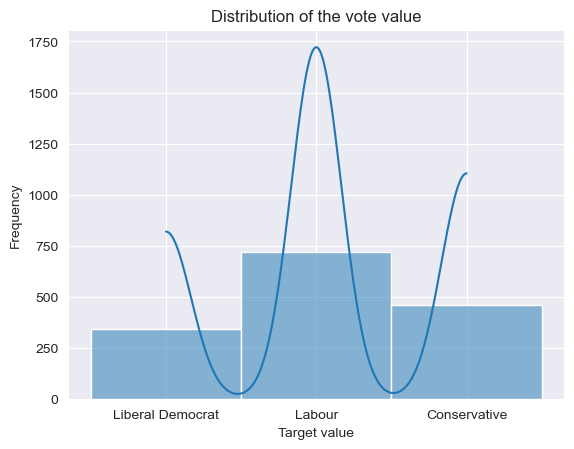

In [20]:
sns.histplot(data=df, x="vote", kde=True)
plt.title('Distribution of the vote value')
plt.xlabel('Target value')
plt.ylabel('Frequency')
plt.show()


### 2.3. Distribution of numerical variables

Plot the distribution of the numerical features.

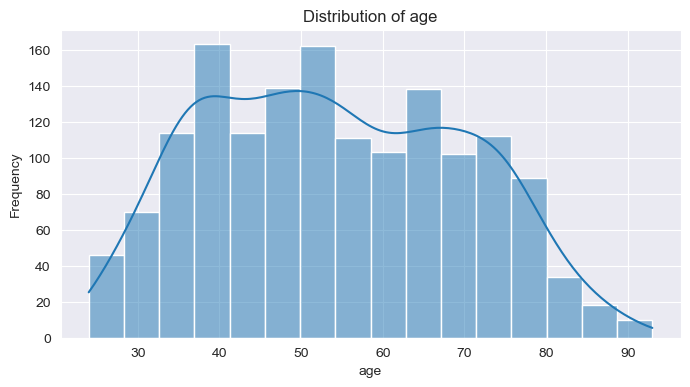

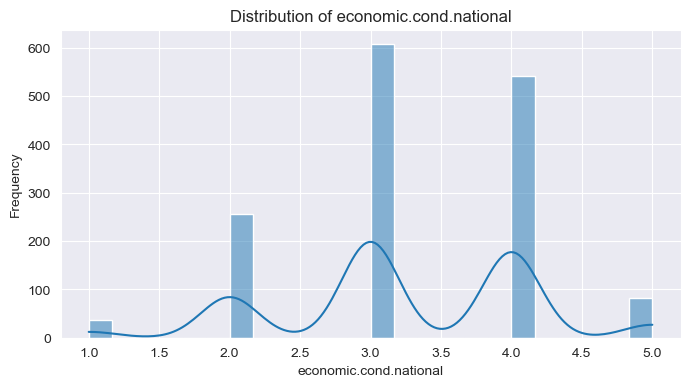

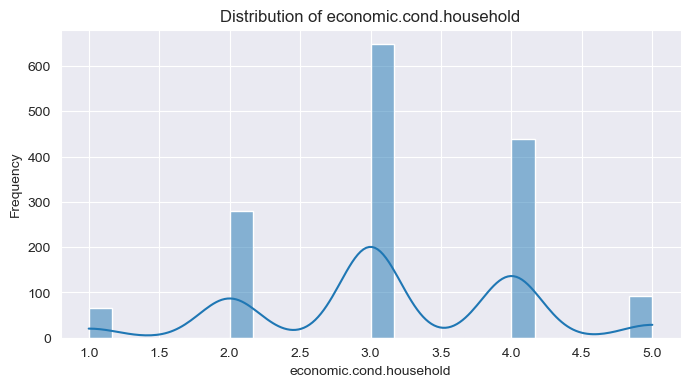

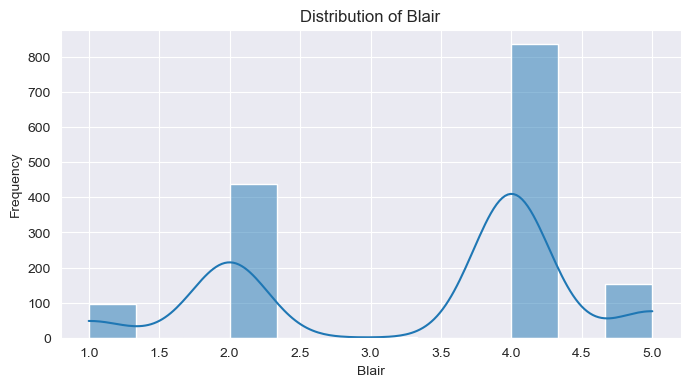

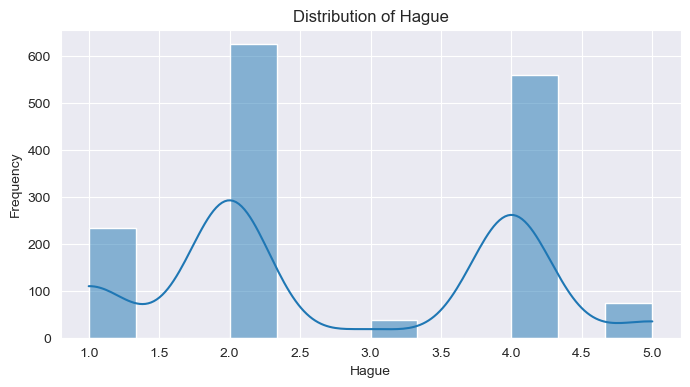

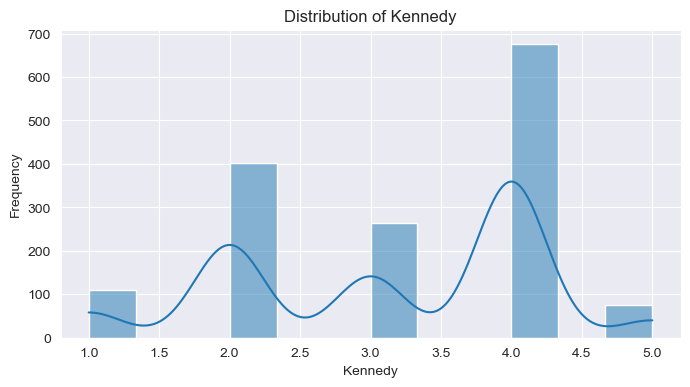

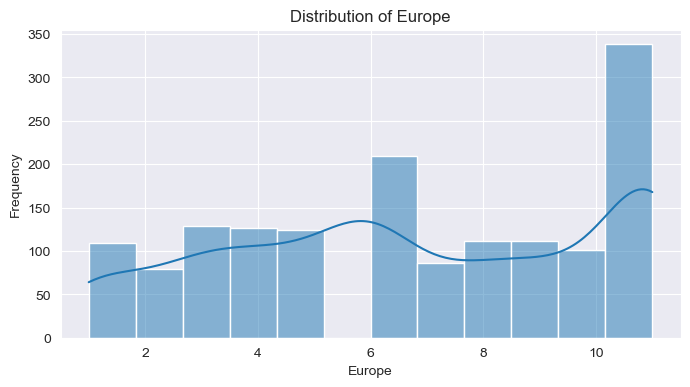

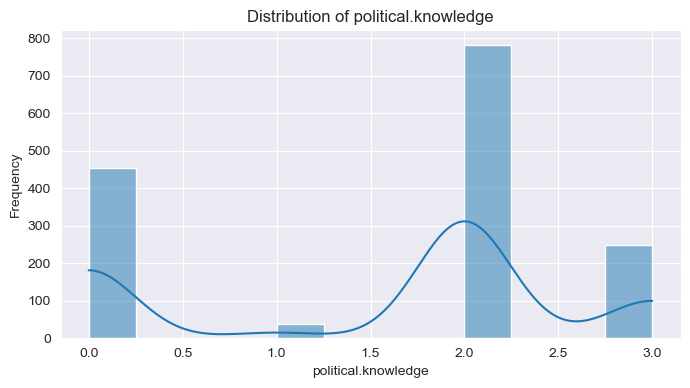

In [21]:
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

### 2.4. Histogram of catagorical variables

Plot the histogram of the catagorical features.

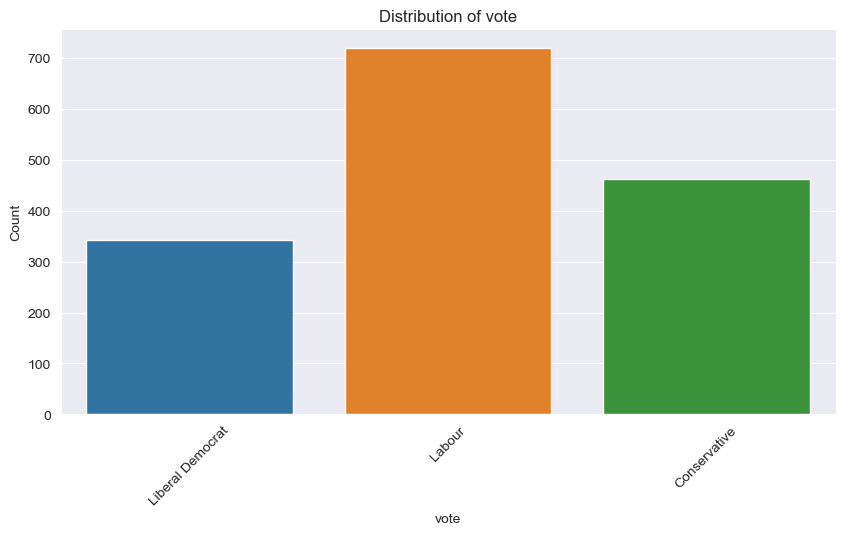

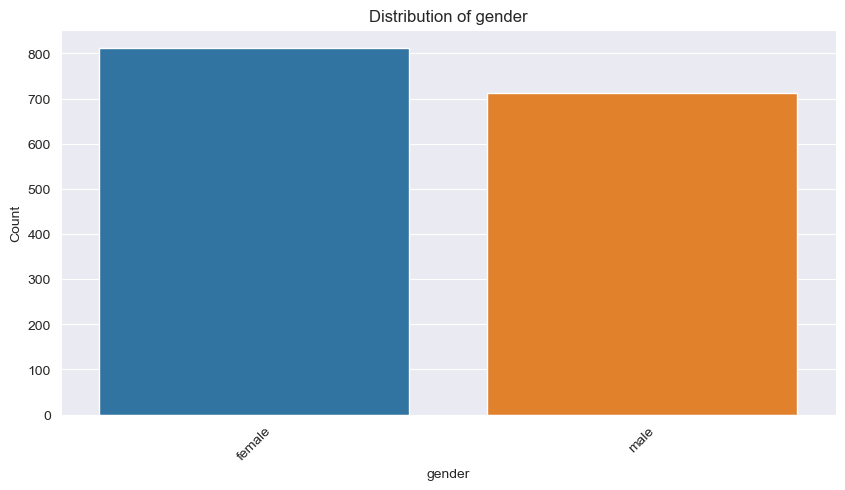

In [22]:
for column in df.select_dtypes(include=['object', 'category']).columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [23]:
X = df.drop('vote', axis=1)  # Features (all columns except the target)
y = df['vote']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Feature Engineering

### 4.1. Scaling numerical variables

In [25]:
numerical_cols = ['age', 'economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'Kennedy', 'Europe', 'political.knowledge']  

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge,gender
0,Liberal Democrat,-0.711973,-0.279218,-0.150948,0.566716,-1.419886,0.799634,-1.434426,0.422643,female
1,Labour,-1.157661,0.856268,0.924730,0.566716,1.018544,0.799634,-0.524358,0.422643,male
2,Labour,-1.221331,0.856268,0.924730,1.418187,-0.607076,-0.124886,-1.131070,0.422643,male
3,Labour,-1.921698,0.856268,-1.226625,-1.136225,-1.419886,-0.124886,-0.827714,-1.424148,female
4,Labour,-0.839313,-1.414704,-1.226625,-1.987695,-1.419886,0.799634,-0.221002,0.422643,male


### 4.2. Catagorical variables encoding

Convert catagorical columns into numerical columns using label encoding or one hot encoding.

In [26]:
categorical_cols = ['vote', 'gender']


label_encoders = {col: LabelEncoder() for col in categorical_cols}


for col, le in label_encoders.items():
    df[col] = le.fit_transform(df[col])


print(df.head())

   vote       age  economic.cond.national  economic.cond.household     Blair  \
0     2 -0.711973               -0.279218                -0.150948  0.566716   
1     1 -1.157661                0.856268                 0.924730  0.566716   
2     1 -1.221331                0.856268                 0.924730  1.418187   
3     1 -1.921698                0.856268                -1.226625 -1.136225   
4     1 -0.839313               -1.414704                -1.226625 -1.987695   

      Hague   Kennedy    Europe  political.knowledge  gender  
0 -1.419886  0.799634 -1.434426             0.422643       0  
1  1.018544  0.799634 -0.524358             0.422643       1  
2 -0.607076 -0.124886 -1.131070             0.422643       1  
3 -1.419886 -0.124886 -0.827714            -1.424148       0  
4 -1.419886  0.799634 -0.221002             0.422643       1  


## 5. Logistic Regression

Fit a logistic regression model on the training set. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

In [28]:
#logistic regression model:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

#Model evaluation:
y_pred = logistic_regression.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1score:", metrics.f1_score(y_test, y_pred, average='macro'))

ValueError: could not convert string to float: 'male'

## 6. Decision Tree

Fit a decision tree model on the training set. Use cross-validation in order to tune the hyperparameters of the decision tree model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

Plot the decision tree.

## 7. Random Forest

Fit a random forest model on the training set. Use cross-validation in order to tune the hyperparameters of the random forest model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

Plot feature importance/weight.

## 8. Gradient Boosting

Fit a gradient boosting model on the training set. Use cross-validation in order to tune the hyperparameters of the gradient boosting model. Evaluate the model on the testing set. Use the Macro F1score as an evaluation metric.

Plot feature importance/weight.